In [1]:
## For debbugging
%load_ext autoreload

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
## for debugging:
%aimport mlp.keyword
%aimport mlp.tools
%aimport mlp.tree
%autoreload 1
from mlp.keyword import *

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook, tqdm
%matplotlib inline

import spacy, textacy, platform
print(
    f'Textacy: \t{textacy.__version__:}'+\
    f'\nspaCy: \t{spacy.__version__:>13}'+\
    f'\nPython: \t{platform.python_version()}'
    )

Textacy: 	0.5.0
spaCy: 	        2.0.4
Python: 	3.6.4


# GS Data (small)

In [4]:
data_directory = os.path.join(module_path,'./data', 'gs_data')
nl_col = {
    "Description": 5,
    "Resolution": 6
}

#TODO
# meta_col = {

# }

kex_gs = KeywordExtractor('Maintenance_All_Clean.xlsx',
                       nlp_cols=nl_col,
#                       meta_cols = meta_col,
                       special_replace={' -': '; '},
                       wdir=data_directory,
                       keep_temp_files=False
                      )

247it [00:00, 2462.68it/s]

making new file...


3435it [00:01, 2379.56it/s]


In [5]:
kex_gs.fit(vocab='tag_vocab.csv')
kex_gs.vocab.head(n=7)

,NE,alias,note
token,,,
replace,S,replace,NaN
unit,I,unit,NaN
motor,I,motor,NaN
spindle,I,spindle,NaN
leak,P,leak,NaN
valve,I,valve,NaN
replaced,S,replace,NaN


## Non-parallel Improvements:

In [9]:
df = kex_gs.df.copy()
tqdm.pandas(desc="KEx")
vocab = kex_gs.vocab.astype(str).copy()

thes_dict = vocab.alias.to_dict()
substr = sorted(thes_dict, key=len, reverse=True)
rx = re.compile('|'.join(map(re.escape, substr)))

toks=df.RawText.str.split()
toks = toks.progress_apply(lambda d: d if isinstance(d, list) else [])
tags = df.RawText.str.replace(rx, lambda match: thes_dict[match.group(0)]).str.split()
tags = tags.progress_apply(lambda d: d if isinstance(d, list) else [])

grps = vocab.groupby('NE')

for cls, grp in grps: 
    s = set(grp['alias'].astype(str).tolist())
    df[cls] = tags.progress_apply(lambda x: list(s.intersection(x))).str.join(', ')

df['unknown'] = toks.progress_apply(lambda x: list(set(x) - set(vocab.index))).str.join(', ')

## This is legacy-style unknown filtering...not used anymore due to str.split() ???
# def get_unknown(x):
#     catch = list(set(x)-set(vocab.index))
#     return [i for i in catch if not np.any(np.isin(list(vocab), i.split(' ')))]
# df['unknown'] = toks.progress_apply(get_unknown).str.join(', ')

df.head()

KEx: 100%|██████████| 3435/3435 [00:00<00:00, 17579.50it/s]


,Description,Resolution,RawText,I,P,R,S,U,X,unknown
0,Broken bar feeder chain,Repaired,break bar feeder chain repair,bar_feeder_chain,broken,,repair,,,
1,No power,Replaced pin in pendant and powered machine; P...,power replace pin pendant powered machine poss...,"machine, pendant, cable, pin","short, power",,replace,,possible,powered
2,Smartscope harness broken,Parts ordered / Tech repaired,smartscope harness broken part order tech repair,person,broken,,"order, repair",,,"harness, smartscope"
3,Check / Charge Accumulators,Where OK,check charge accumulator ok,,check,,"charge, check",,ok,
4,Hyd leak at saw atachment,Replaced seal in saw attachment but still leak...,hyd leak saw atachment replace seal saw attach...,"saw_attachment, saw",leak,,replace,,,"pend, reapir, ml, atachment"


## Dask Parallelizations

In [6]:
import dask.dataframe as dd
# import dask

ddf = dd.from_pandas(kex_gs.df, npartitions=8)
vocab = kex_gs.vocab.astype(str).copy()

thes_dict = vocab.alias.to_dict()
substr = sorted(thes_dict, key=len, reverse=True)
rx = re.compile('|'.join(map(re.escape, substr)))

toks = ddf.RawText.str.split()
toks = toks.apply(lambda d: d if isinstance(d, list) else [], 
                             meta=toks)

tags = ddf.RawText.str.replace(rx, lambda match: thes_dict[match.group(0)]).str.split()
tags = tags.apply(lambda d: d if isinstance(d, list) else [], 
                             meta=tags)

grps = vocab.groupby('NE')

# have to pre-allocate column names...dask doesn't like loops :(
tagI = tags.apply(lambda x: list(set(grps.get_group('I')['alias'].astype(str).tolist()) & set(x)),
                  meta=('I', object)).str.join(', ')
tagP = tags.apply(lambda x: list(set(grps.get_group('P')['alias'].astype(str).tolist()) & set(x)),
                  meta=('P', object)).str.join(', ')
tagS = tags.apply(lambda x: list(set(grps.get_group('S')['alias'].astype(str).tolist()) & set(x)),
                  meta=('S', object)).str.join(', ')

tagU = toks.apply(lambda x: list(set(x) - set(vocab.index)),
                  meta=('U', object)).str.join(', ')

ndf = dd.concat([ddf, tagI, tagP, tagS, tagU], axis=1)


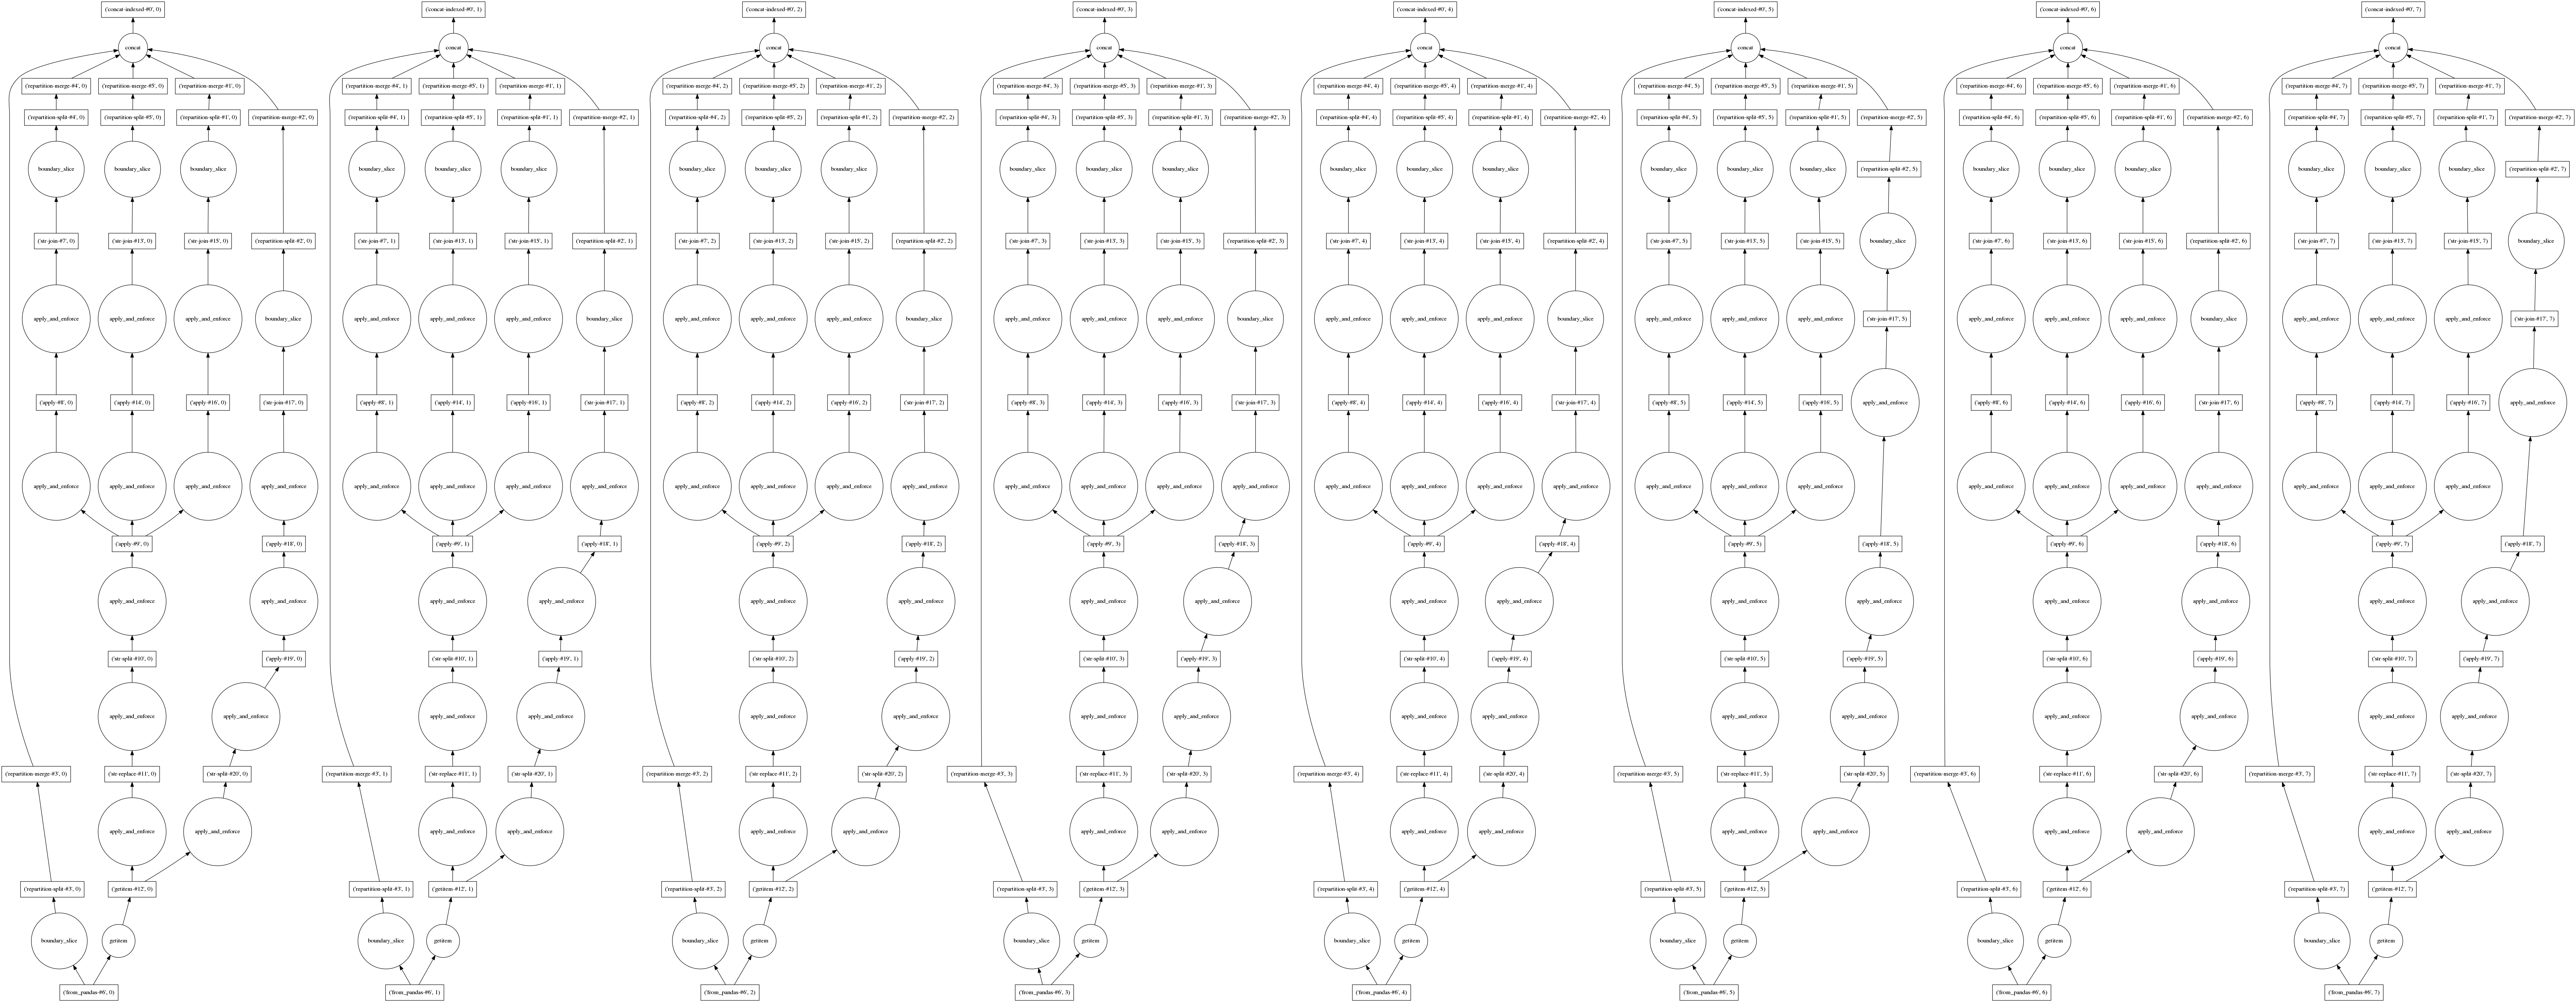

In [7]:
from dask.dot import dot_graph
dot_graph(ndf.dask)

In [8]:
from dask.diagnostics import ProgressBar, Profiler, ResourceProfiler, CacheProfiler, visualize
from dask.distributed import Client
import dask

## multiproc, not thread, due to GIL with text. 
with Profiler() as prof, ResourceProfiler(dt=0.25) as rprof, CacheProfiler() as cprof:
    with ProgressBar(), dask.set_options(get=dask.multiprocessing.get):
        df = ndf.compute()

visualize([prof, rprof, cprof])
df.head()

## this is even faster, go to <localhost:8787/status>
# client = Client()
# df = ndf.compute()

[########################################] | 100% Completed |  2.8s


,Description,Resolution,RawText,I,P,S,U
0,Broken bar feeder chain,Repaired,break bar feeder chain repair,bar_feeder_chain,broken,repair,
1,No power,Replaced pin in pendant and powered machine; P...,power replace pin pendant powered machine poss...,"pendant, cable, machine, pin","power, short",replace,powered
2,Smartscope harness broken,Parts ordered / Tech repaired,smartscope harness broken part order tech repair,person,broken,"repair, order","smartscope, harness"
3,Check / Charge Accumulators,Where OK,check charge accumulator ok,,check,"charge, check",
4,Hyd leak at saw atachment,Replaced seal in saw attachment but still leak...,hyd leak saw atachment replace seal saw attach...,"saw_attachment, saw",leak,replace,"reapir, ml, pend, atachment"


# Mining Data (big-ish)

In [9]:
data_directory = os.path.join(module_path, './data', 'mine_data')

# nl_col = {
#     "OriginalShorttext": 2
# }
# meta_col = {
#     "BscStartDate":0,
#     "Asset":1,
#     "PMType":3,
#     "Cost":4
# }

nl_col = {
    "ShortText": 4
}
meta_col = {
    "BscStartDate":2,
    "AssetID":13
}

# kex_mine = KeywordExtractor('mine_data.csv',
kex_mine = KeywordExtractor('loader_work_orders_sanitised.csv',
                       nlp_cols=nl_col,
                      meta_cols = meta_col,
                      special_replace={'not ': 'not_'},
                       wdir=data_directory,
                       keep_temp_files=False
                      )

Unsupported format, or corrupt file: Expected BOF record; found b'"WOType"' ... did not find .xlsx file, attempting .csv ...


599it [00:00, 5986.82it/s]

making new file...


269830it [10:30, 427.83it/s]

KeyboardInterrupt: 

In [54]:
# use this to make a properly formatted thesaurus file for human-annotation
# kex_mine.gen_vocab('mine_vocab_full.csv', notes=True)  # rename to match e.g. hvac_vocab.csv


In [5]:
# "fit" a thesaurus to the data
kex_mine.fit(vocab='mine_vocab.csv')
kex_mine.vocab.head()

,NE,alias,note
token,,,
replace,S,replace,NaN
leak,P,leak,NaN
repair,S,repair,NaN
bucket,I,bucket,NaN
engine,I,engine,NaN


In [65]:
df = kex_mine.df.copy()
vocab = kex_mine.vocab.astype(str).copy()

thes_dict = vocab.alias.to_dict()
substr = sorted(thes_dict, key=len, reverse=True)
rx = re.compile('|'.join(map(re.escape, substr)))
def one_xlat(match):
    return thes_dict[match.group(0)]

toks=df.RawText.str.split()
toks = toks.progress_apply(lambda d: d if isinstance(d, list) else [])
tags = df.RawText.str.replace(rx, one_xlat).str.split()
tags = tags.progress_apply(lambda d: d if isinstance(d, list) else [])

grps = vocab.groupby('NE')


df['I'] = tags.progress_apply(lambda x: list(set(grps.get_group('I')['alias'].astype(str).tolist()) & set(x)))
df['P'] = tags.progress_apply(lambda x: list(set(grps.get_group('P')['alias'].astype(str).tolist()) & set(x)))
df['S'] = tags.progress_apply(lambda x: list(set(grps.get_group('S')['alias'].astype(str).tolist()) & set(x)))


df['unknown'] = toks.progress_apply(lambda x: list(set(x) - set(vocab.index)))

df.head(10)

KEx: 100%|██████████| 696211/696211 [00:17<00:00, 38723.84it/s]


,BscStartDate,ShortText,AssetID,RawText,I,P,S,unknown
0,10/7/05,replace lube tank fill hose.,AID1,replace lube tank fill hose,"[tank, hose]",[],"[fill, replace]",[]
1,10/7/05,checked rotary head alignment,AID2,check rotary head alignment,[],[],[check],"[head, alignment, rotary]"
2,10/7/05,reweld shock sub to rotary head,AID2,reweld shock sub rotary head,[],[],[],"[sub, head, reweld, shock, rotary]"
3,27/7/05,centre tank not filling with water,AID2,centre tank not_fill water,"[tank, water]",[],[],"[not_fill, centre]"
4,2/7/01,hydraulic pump failure,AID3,hydraulic pump failure,"[hydraulic, pump]",[],[],[failure]
5,1/7/01,pump drive box coupling and shaft u/s.,AID4,pump drive box coupling shaft u s,"[pump_drive, box]",[],[],"[u, coupling, shaft, s]"
6,11/7/05,repair engine excessive blowby,AID5,repair engine excessive blowby,[engine],[],[repair],"[blowby, excessive]"
7,16/7/05,two broken growser bolts r/h side,AID2,break growser bolt r h,"[bolt, right_hand]",[broken],[],"[growser, r, h]"
8,27/7/05,adjust all head slides,AID2,adjust head slide,[],[],[adjust],"[head, slide]"
9,27/7/05,change out main gearbox oil to 85/140,AID2,change main gearbox oil 85/140,"[oil, gearbox, main]",[],[change],[85/140]


In [23]:
import dask.dataframe as dd
# import dask

ddf = dd.from_pandas(kex_mine.df, npartitions=8)
vocab = kex_mine.vocab.astype(str).copy()

thes_dict = vocab.alias.to_dict()
substr = sorted(thes_dict, key=len, reverse=True)
rx = re.compile('|'.join(map(re.escape, substr)))

toks = ddf.RawText.str.split()
toks = toks.apply(lambda d: d if isinstance(d, list) else [], 
                             meta=toks)

tags = ddf.RawText.str.replace(rx, lambda match: thes_dict[match.group(0)]).str.split()
tags = tags.apply(lambda d: d if isinstance(d, list) else [], 
                             meta=tags)

grps = vocab.groupby('NE')

tagI = tags.apply(lambda x: list(set(grps.get_group('I')['alias'].astype(str).tolist()) & set(x)),
                  meta=('I', object))
tagP = tags.apply(lambda x: list(set(grps.get_group('P')['alias'].astype(str).tolist()) & set(x)),
                  meta=('P', object))
tagS = tags.apply(lambda x: list(set(grps.get_group('S')['alias'].astype(str).tolist()) & set(x)),
                  meta=('S', object))

tagU = toks.apply(lambda x: list(set(x) - set(vocab.index)),
                  meta=('U', object))

ndf = dd.concat([ddf, tagI, tagP, tagS, tagU], axis=1)


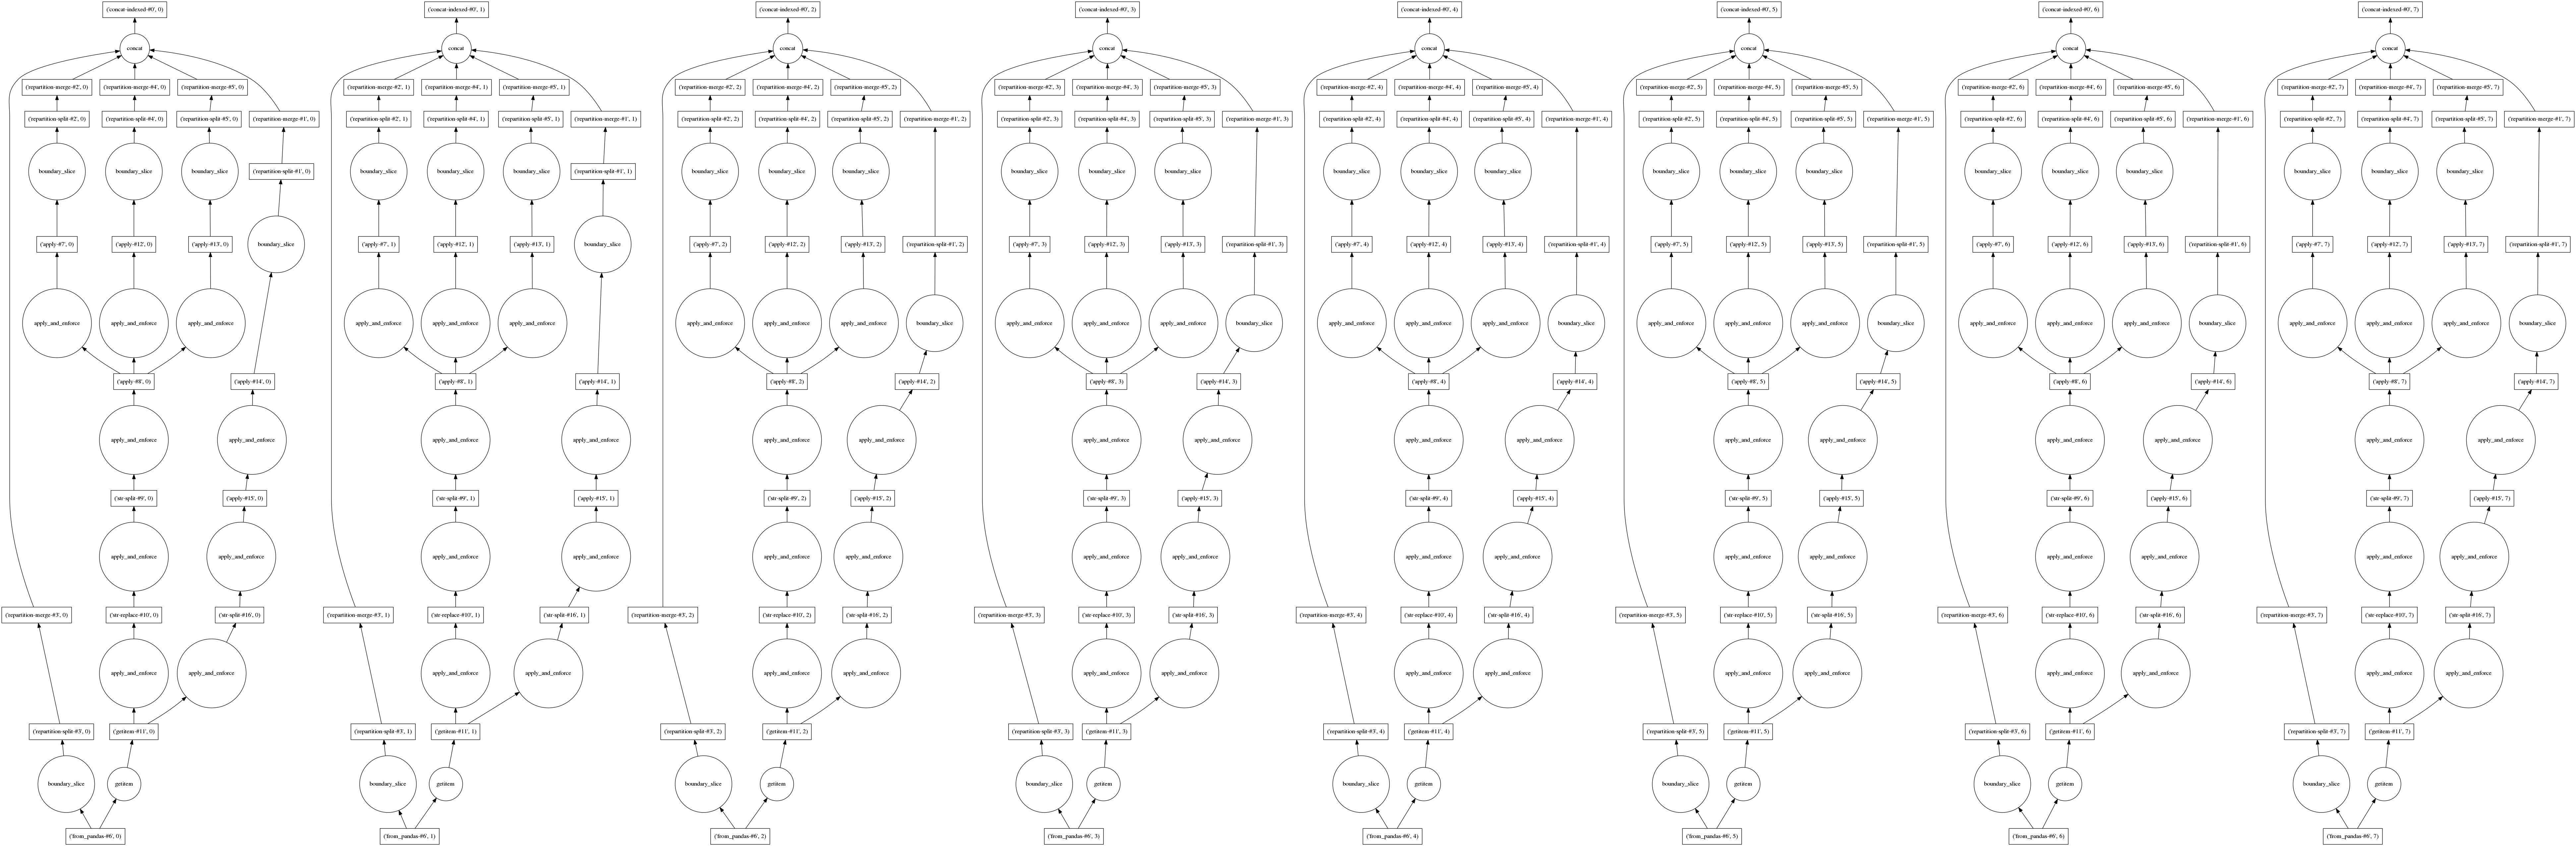

In [24]:
from dask.dot import dot_graph
dot_graph(ndf.dask)

In [27]:
from dask.diagnostics import ProgressBar, Profiler, ResourceProfiler, CacheProfiler, visualize
from dask.distributed import Client
# with ProgressBar(), Profiler() as prof, ResourceProfiler(dt=0.25) as rprof, CacheProfiler() as cprof, dask.set_options(get=dask.multiprocessing.get):
#     df = ndf.compute()
client = Client()
# future = client.compute(ndf)
df = ndf.compute()